In [1]:
%%latex
\author{name}
\title{title}
\date{date}
\maketitle

<IPython.core.display.Latex object>

# Pre-processing

In [2]:
from math import sqrt

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
housing = pd.read_csv("../data/housing.txt", sep='\s+')

In [4]:
housing.head()

,Value,Rooms,%Aged,PT-Ratio,%Lower
0,24000,6.6,65,15.3,5.0
1,21600,6.4,79,17.8,9.1
2,34700,7.2,61,17.8,4.0
3,33400,7.0,46,18.7,2.9
4,36200,7.1,54,18.7,5.3


In [5]:
housing.describe()

,Value,Rooms,%Aged,PT-Ratio,%Lower
count,506.000000,506.000000,506.000000,506.000000,504.000000
mean,22532.806324,6.238142,68.616601,18.455534,12.672817
std,9197.104087,1.042763,28.138400,2.164946,7.148724
min,5000.000000,-6.200000,3.000000,12.600000,1.700000
25%,17025.000000,5.900000,45.000000,17.400000,6.975000
50%,21200.000000,6.200000,77.500000,19.050000,11.350000
75%,25000.000000,6.600000,94.000000,20.200000,17.025000
max,50000.000000,8.800000,100.000000,22.000000,38.000000


In [6]:
housing.isna().sum()

Value       0
Rooms       0
%Aged       0
PT-Ratio    0
%Lower      2
dtype: int64

We can verify that there are 2 missing values in the "%Lower" variable.

In [7]:
housing[housing['%Lower'].isnull()]

,Value,Rooms,%Aged,PT-Ratio,%Lower
36,20000,5.8,61,19.2,NaN
250,24400,6.5,13,19.1,NaN


For row 36, we may replace the "NaN" with its mean, because other variables of the same row are close to their means. It's harder to assign a replacement for row 250, as the "%Aged" variable is far away from its mean, while other variables are closer to theirs. However, this way of thinking assumes linear relationships amongst the variables, which may or may not be the case. Given the small number of missing values (2 out of 506), it may be best to simply drop them, as their impact on the dataset is more likely to be minimal.

In [8]:
housing.dropna().describe()

,Value,Rooms,%Aged,PT-Ratio,%Lower
count,504.000000,504.000000,504.000000,504.000000,504.000000
mean,22534.126984,6.238492,68.742063,18.452778,12.672817
std,9214.302244,1.044586,28.082684,2.168799,7.148724
min,5000.000000,-6.200000,3.000000,12.600000,1.700000
25%,16950.000000,5.900000,45.000000,17.375000,6.975000
50%,21200.000000,6.200000,78.000000,19.000000,11.350000
75%,25000.000000,6.600000,94.000000,20.200000,17.025000
max,50000.000000,8.800000,100.000000,22.000000,38.000000


We can verify dropping the two rows with missing values does not change much of the summary statistics.

In [9]:
housing_no_missing = housing.dropna()
housing_no_missing[housing_no_missing.Rooms < 0]

,Value,Rooms,%Aged,PT-Ratio,%Lower
15,19900,-5.8,57,21.0,8.5
83,22900,-6.2,47,19.0,7.5


Another issue with the data is the negative values in the "Rooms" variable, which represents the "(a)verage number of rooms per dwelling". The number of rooms obviously cannot be negative. It looks more likely a case of mistaken records: the negative sign was probably added by accident. So we change both values to their positive counterparts.

In [10]:
neg_index = housing_no_missing.Rooms < 0

housing_no_neg = housing_no_missing.drop(housing_no_missing[neg_index].index)

housing_neg_to_posi = housing_no_missing[neg_index].assign(
    Rooms = lambda df:df.Rooms.abs()
)

h = housing_neg_to_posi.append(housing_no_neg).sort_index()

Here, we replace the negative values with their positive counterparts.

In [11]:
h.loc[neg_index]

,Value,Rooms,%Aged,PT-Ratio,%Lower
15,19900,5.8,57,21.0,8.5
83,22900,6.2,47,19.0,7.5


In [12]:
sum(h.Rooms < 0)

0

We can verify they are now both positive and there is no negative values in "Rooms". To be sure, we take another look at the summary statistics.

In [13]:
h.describe()

,Value,Rooms,%Aged,PT-Ratio,%Lower
count,504.000000,504.000000,504.000000,504.000000,504.000000
mean,22534.126984,6.286111,68.742063,18.452778,12.672817
std,9214.302244,0.702541,28.082684,2.168799,7.148724
min,5000.000000,3.600000,3.000000,12.600000,1.700000
25%,16950.000000,5.900000,45.000000,17.375000,6.975000
50%,21200.000000,6.200000,78.000000,19.000000,11.350000
75%,25000.000000,6.600000,94.000000,20.200000,17.025000
max,50000.000000,8.800000,100.000000,22.000000,38.000000


The summary statistics all seem to be reasonable now.

# Analysis

In [14]:
# function for calculating coef, slope and intercept

def get_linreg(var1, var2):
    var1_mean = var1.mean()
    var2_mean = var2.mean()

    sum1 = 0
    sum2 = 0
    sum3 = 0

    for i in var1.index:
        sum1 += (var1[i] - var1_mean) * (var2[i] - var2_mean)
        sum2 += (var1[i] - var1_mean) ** 2
        sum3 += (var2[i] - var2_mean) ** 2
    coef = sum1 / (sqrt(sum2) * sqrt(sum3))

    slope = sum1 / sum2

    intercept = var2_mean - slope * var1_mean

    return coef, slope, intercept

In [15]:
l1 = pd.DataFrame(get_linreg(h['Rooms'], h['Value'])).T
l2 = pd.DataFrame(get_linreg(h['%Aged'], h['Value'])).T
l3 = pd.DataFrame(get_linreg(h['PT-Ratio'], h['Value'])).T
l4 = pd.DataFrame(get_linreg(h['%Lower'], h['Value'])).T

lns = pd.concat([l1,l2,l3,l4], ignore_index=True)
lns.columns = ['p-coef', 'slope', 'intercept']
lns.index = ["Rooms-Value", "%Aged-Value", "PT-Ratio-Value", "%Lower-Value"]
lns

,p-coef,slope,intercept
Rooms-Value,0.696273,9132.093458,-34871.227172
%Aged-Value,-0.377768,-123.950816,31054.761840
PT-Ratio-Value,-0.507882,-2157.773660,62351.044831
%Lower-Value,-0.737981,-951.216347,34588.718119


# Visualization

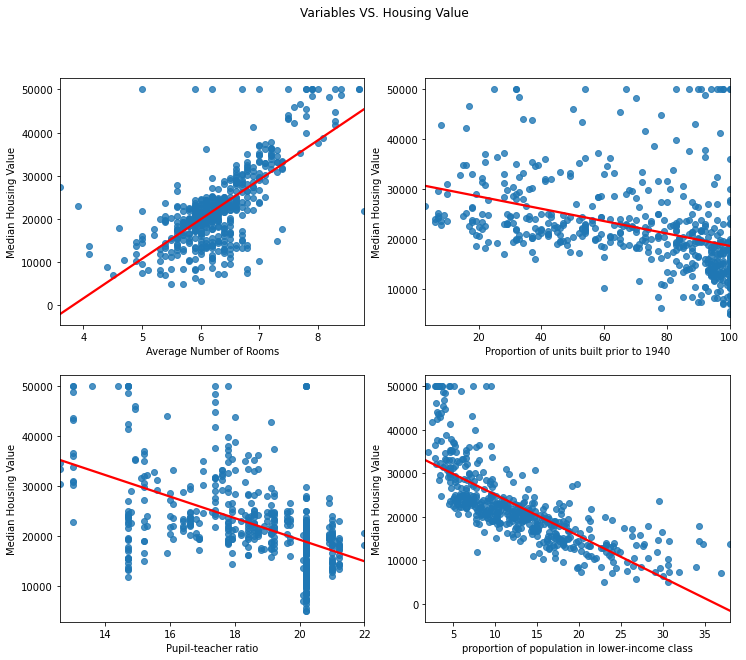

In [16]:
plt.figure(figsize=(12,10))

plt.subplot(2, 2, 1)

s_rv = sns.regplot(x=h['Rooms'], y=h.Value, data=h, ci=None, line_kws={'color': 'red'})
s_rv.set(xlabel="Average Number of Rooms", ylabel="Median Housing Value")

plt.subplot(2, 2, 2)

s_av = sns.regplot(x=h['%Aged'], y=h.Value, data=h, ci=None, line_kws={'color': 'red'})
s_av.set(xlabel="Proportion of units built prior to 1940", ylabel="Median Housing Value")

plt.subplot(2, 2, 3)

s_pv = sns.regplot(x=h['PT-Ratio'], y=h.Value, data=h, ci=None, line_kws={'color': 'red'})
s_pv.set(xlabel="Pupil-teacher ratio", ylabel="Median Housing Value")

plt.subplot(2, 2, 4)

s_lv = sns.regplot(x=h['%Lower'], y=h.Value, data=h, ci=None, line_kws={'color': 'red'})
s_lv.set(xlabel="proportion of population in lower-income class", ylabel="Median Housing Value")

plt.suptitle("Variables VS. Housing Value")
plt.show()

# Discussion

We see that the average number of rooms seems to be positively correlated with housing values, whereas old units proportion (proportion of units built prior to 1940), pupil-teach ratio, and lower-income class proportion all seem to be negatively associated with housing value. Of these relationships, the one between lower-income class proportion and housing value exhibits the most correlation, with a Pearson correlation coefficient of about -0.74, suggesting that the proportion of lower-income class has the most impact on housing value in the dataset.

Compared with others, we see a lot more variance in the old units proportion versus median housing value plot and the pupil-teacher ratio versus median housing value plot. In the plot for average number of rooms versus median housing value, there seem to be some outliers at the top. The general shape of data points in the proportion of lower-income class population versus median housing value plot seems more fitting for a curve than a straight line. These are all questions worth exploring for further analysis.
